In [1]:
# Importing necessary files.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob, os

# Added dask to accelerate data handling.
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

# Turn off the pandas warnings and alerts.
import warnings
warnings.simplefilter(action='ignore')

In [3]:
# Collect all dates in a tuple.
dates_tuple = tuple([f'202402'+str(i) if i>=10 else '2024020'+str(i)  for i in range(1,30)] + 
                    [f'202403'+str(i) if i>=10 else '2024030'+str(i)  for i in range(1,32)])
# Define subfolders shorthand for smoother manipulation.
subfolders_dic = {'match':'raw_match_parquet',
                  'odds':'raw_odds_parquet',
                  'pbp':'raw_point_by_point_parquet',
                  'stats':'raw_statistics_parquet',
                  'power':'raw_tennis_power_parquet',
                  'votes':'raw_votes_parquet'
                  }
# Define function to render addresses.
def render_addresses(subfolder:str, date_arr = None, kind:str = ""):
    """
    Function to render addresses.
    It takes a subfolder, array of dates and kind of file as inputs.
    """
    result = []
    date_arr = dates_tuple if not date_arr else date_arr
    if kind:
        result = [file for dt in date_arr
        for file in glob.glob(f"Tennis Schema\\{dt}\\data\\raw\\{subfolders_dic[subfolder]}\\{kind}_[!s]*.parquet")]
    else:
        result = [file for dt in date_arr
        for file in glob.glob(f"Tennis Schema\\{dt}\\data\\raw\\{subfolders_dic[subfolder]}\\*.parquet")]
    return result

### 1.

In [ ]:
# How many players are there in the dataset?
# Let me find all the data associated with players in the parquet files.
# We just need ID of the players to distinguish them, no need to their name or other personal information.
players_id_df = dd.read_parquet(render_addresses('match', kind='*_team'),columns=['player_id'])

In [167]:
# Extracting the results into csv for faster manipulation with pandas.
with ProgressBar():
    result = players_id_df.compute()

[########################################] | 100% Completed | 119.58 s


In [ ]:
# A first look at the fetched results.
# I save this dataframe in a csv file, so as to access the retrieved data faster later on.
result

,player_id
0,192013
0,273680
0,77223
0,88992
0,248846
...,...
0,375214
0,215205
0,398073
0,303293


In [5]:
# Load the CSV, drop duplicates and count the unique players.
players_df = pd.read_csv("CSVs\\1_players_id.csv")

# Drop repetitive players, to find the unique ones.
players_df.drop_duplicates(subset='player_id', inplace=True)

# You can check that there is no NULL record in `player_id` field.
print(f"There are {players_df.shape[0]} distinct players in the dataset.")

There are 2644 distinct players in the dataset.


### 2.

In [ ]:
# The average height of players.
# Now, I just read the height information of players, along with their ID.
players_height_df =dd.read_parquet(render_addresses('match', kind='*_team'),columns=['player_id','height'])

In [177]:
# Extracting the results into csv for faster manipulation with pandas.
with ProgressBar():
    result = players_height_df.compute()

[########################################] | 100% Completed | 121.35 s


In [ ]:
# A first look at the fetched results.
# I save this dataframe in a csv file, so as to access the retrieved data faster later on.
result

,player_id,height
0,192013,1.93
0,273680,1.83
0,77223,1.85
0,88992,1.83
0,248846,1.78
...,...,...
0,375214,NaN
0,215205,1.75
0,398073,1.91
0,303293,NaN


In [6]:
# Load the CSV, drop duplicates and nan values, then find the average of height.
heights_df = pd.read_csv("CSVs\\2_players_height.csv")

# Droping the duplicated players.
heights_df.drop_duplicates(subset='player_id', keep='first',inplace=True)

# Dropping the missing values.
heights_df.dropna(subset=['height'], inplace=True)

# Average height.
avg_height = heights_df['height'].mean()

print(f"Average height of players in the dataset is {avg_height:.3f} m, or {avg_height*100:.1f} cm.")

Average height of players in the dataset is 1.821 m, or 182.1 cm.


### 3.

In [165]:
# Extracting the necessary coulumns of tables for finding the player with highest number of wins.
# I need to join matches, with players dataframe.
event_addresses = render_addresses('match', date_arr = dates_tuple,kind='event')
home_addresses = render_addresses('match', date_arr = dates_tuple, kind='home_team')
away_addresses = render_addresses('match', date_arr = dates_tuple, kind='away_team')

match_df = dd.read_parquet(event_addresses, columns=['match_id','winner_code'])
home_df = dd.read_parquet(home_addresses, columns=['match_id','player_id','full_name'])
away_df = dd.read_parquet(away_addresses, columns=['match_id','player_id','full_name'])

In [166]:
# Extracting the results into csv for faster manipulation with pandas.
with ProgressBar():
    result = away_df.compute()

[########################################] | 100% Completed | 71.09 s


In [167]:
# A first look at the fetched results.
# I save this dataframe in a csv file, so as to access the retrieved data faster later on.
result

,match_id,player_id,full_name
0,11998445,192013,"Auger-Aliassime, Felix"
0,11998446,273680,Flavio Cobolli
0,11998447,77223,"Martinez, Pedro"
0,11998448,88992,"Muller, Alexandre"
0,11998449,248846,"Mayot, Harold"
...,...,...,...
0,12212216,72324,"Doria, Luciano"
0,12213156,217437,"Soriano Barrera, Adria"
0,12213412,108559,"Taberner, Carlos"
0,12213458,74679,"Simonsson, Fred"


In [7]:
# Opening folders and then dropping duplicates.
match_df = pd.read_csv("CSVs\\3_match_df.csv")
home_df = pd.read_csv("CSVs\\3_home_df.csv")
away_df = pd.read_csv("CSVs\\3_away_df.csv")

# Dropping duplicated records, with the logic that each of these three dataframes must contain unique `match_id`s.
match_df.drop_duplicates(subset='match_id', inplace=True)
home_df.drop_duplicates(subset='match_id', inplace=True)
away_df.drop_duplicates(subset='match_id', inplace=True)

In [8]:
# Joining tables and combining them.
# In the match_df dataframe, `winner_code` indicates the winner. 1 for home and 2 for away.
# So I join winner == 1 with home_df on match_id, and winner == 2 with away_df.
winner_home_df = match_df.query('winner_code == 1').merge(home_df, on='match_id', how='inner')
winner_home_df = winner_home_df.drop(columns=['winner_code'])
winner_away_df = match_df.query('winner_code == 2').merge(away_df, on='match_id', how='inner')
winner_away_df = winner_away_df.drop(columns=['winner_code'])

# Concating the result, and dropping dropping possible duplicated results.
winners_df = pd.concat([winner_home_df,winner_away_df])
winners_df = winners_df.dropna().drop_duplicates()
winners_df.player_id = winners_df.player_id.astype(int)

In [9]:
winners_df

,match_id,player_id,full_name
0,11998447,64580,"Ćorić, Borna"
1,11998448,131442,"Mmoh, Michael"
2,11998451,264344,"Shevchenko, Alexander"
3,11998459,283070,"Rune, Holger"
4,11998667,46390,"Uchiyama, Yasutaka"
...,...,...,...
5493,12212205,405124,"Ratti, Lucio"
5494,12212207,170976,"Ribero, Franco"
5495,12212215,329576,"Simonit, Ezequiel"
5496,12213412,108559,"Taberner, Carlos"


In [180]:
# Group the winnder_df and aggregate the resulting groups.
df_ = winners_df.groupby('player_id').agg({'match_id':'count',
                                    'full_name':'min'}).rename(
                                    columns={'match_id':'matches_won'}).sort_values(
                                    'matches_won',ascending=False)

print(f"As you see {df_.iloc[0,1]} has has the hightst win numbers, with {df_.iloc[0,0]} wins.")
df_

As you see Popko, Dmitry has has the hightst win numbers, with 29 wins.


,matches_won,full_name
player_id,,
50901,29,"Popko, Dmitry"
231620,22,"Chidekh, Clement"
202572,21,"Gengel, Marek"
230049,21,"Jianu, Filip Cristian"
82133,20,"Dellien Velasco, Murkel Alejandro"
...,...,...
175258,1,"Benaissa, Amira"
175160,1,"Lavino, Irene"
59213,1,"Perez Garcia, Maria Paulina"


### 4.

In [181]:
# Extracting the time results into csv for faster manipulation with pandas.
time_df = dd.read_parquet(render_addresses('match', kind='time'))

# Extracting the results into csv for faster manipulation with pandas.
with ProgressBar():
    result = time_df.compute()

# A first look at the fetched results.
# I save this dataframe in a csv file, so as to access the retrieved data faster later on.
result

[########################################] | 100% Completed | 160.13 s


,match_id,period_1,period_2,period_3,period_4,period_5,current_period_start_timestamp
0,11974053,None,None,None,None,None,None
0,11974066,None,None,None,None,None,None
0,11998445,3259,2639,4202,None,None,1706816851
0,11998446,2488,2375,None,None,None,1706803981
0,11998447,3741,1913,None,None,None,1706798459
...,...,...,...,...,...,...,...
0,12213482,5,138,None,None,None,1711985032
0,12213483,3330,3574,None,None,None,1711982605
0,12213484,3,5,None,None,None,1711984742
0,12213486,1968,3697,None,None,None,1711980823


In [182]:
# Load the data.
time_df = pd.read_csv("CSVs\\4_time_df.csv")
time_df.drop_duplicates(subset='match_id', inplace=True)
# If period_1 is not recorded, all the other sets are not recorded and we do not have the data of duration of these matches.
time_df.dropna(subset=['period_1'], inplace=True)
# All the matches have 3 sets, so periods 4 and 5 are NULL. I drop the unnecessary columns.
time_df.drop(columns=['period_4','period_5','current_period_start_timestamp'], inplace=True)
# Find the total duration and turn into minutes.
time_df['duration'] = time_df[['period_1', 'period_2', 'period_3']].sum(axis=1, skipna=True).div(60).round(2)
# Sort the result.
time_df.sort_values(by=['duration'],ascending=False)

,match_id,period_1,period_2,period_3,duration
5799,12063611,167352.0,169438.0,NaN,5613.17
5795,12063587,159144.0,161086.0,NaN,5337.17
30980,12185562,4163.0,84588.0,88380.0,2952.18
17230,12121829,172605.0,810.0,NaN,2890.25
3803,12054403,2170.0,80162.0,81551.0,2731.38
...,...,...,...,...,...
1026,12039701,77.0,26.0,NaN,1.72
35668,12213484,3.0,5.0,NaN,0.13
6344,12064959,2.0,6.0,NaN,0.13
5853,12063889,4.0,4.0,NaN,0.13


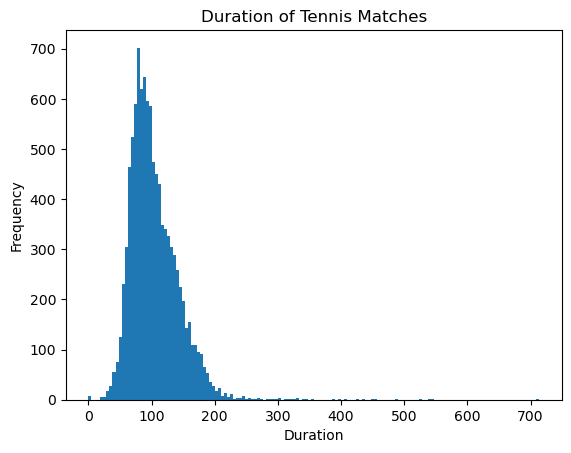

In [183]:
# The results seem very strange, let me look at their distribution.
time_df.query("duration < 800").duration.plot.hist(bins=150)
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.title('Duration of Tennis Matches')
plt.show()

In [187]:
# About Only 1% of whole matches are longer than 295 minutes.
time_cut = time_df.duration.quantile(0.99)

In [188]:
# Outlier deleting
time_df.drop(index = time_df.query("duration > @time_cut").index, axis=1, inplace= True)

In [ ]:
time_df.sort_values(by='duration',ascending=False)

,match_id,period_1,period_2,period_3,duration
28461,12170628,2821.0,13335.0,1535.0,294.85
20031,12131381,1930.0,15656.0,NaN,293.10
20257,12137174,2320.0,1230.0,13849.0,289.98
33738,12197940,13584.0,3374.0,NaN,282.63
29830,12174579,6033.0,8100.0,2226.0,272.65
...,...,...,...,...,...
1026,12039701,77.0,26.0,NaN,1.72
35668,12213484,3.0,5.0,NaN,0.13
6344,12064959,2.0,6.0,NaN,0.13
5853,12063889,4.0,4.0,NaN,0.13


In [ ]:
# There are possibly mistakes in entering data to the dataset, since a game could not last for 96 hours.
# Look at https://www.sofascore.com/fr/tennis/match/o-gavrila-carolina-alves/OLvsnbR
# This shows that indeed data entry has some flaws.
# After deleting outliers and anomalies, we have
print(f"The longest game has lasted {time_df.duration.sort_values(ascending=False).iloc[0]:.1f} minutes.")
print(f"It is associated with match_id == 12170628")

The longest game has lasted 294.9 minutes.
It is associated with match_id == 12170628


### 5.

In [202]:
# Extracting the results into csv for faster manipulation with pandas.
with ProgressBar():
    result = dd.read_parquet(render_addresses('match', kind="event"), columns = ['default_period_count']).compute()

# A first look at the fetched results.
# I save this dataframe in a csv file, so as to access the retrieved data faster later on.
result

[########################################] | 100% Completed | 118.87 s


,default_period_count
0,3
0,3
0,3
0,3
0,3
...,...
0,3
0,3
0,3
0,3


In [ ]:
sets_df = pd.read_csv("CSVs\\5_sets.csv")
sets_df.value_counts().reset_index()

,default_period_count,count
0,3,35053


In [ ]:
# As you see, all the recorded matches are played in 3 sets.

### 6.

In [48]:
# Extracting the necessary coulumns for the player with highest number of wins.
home_addresses = render_addresses('match', date_arr = dates_tuple, kind='home_team')
away_addresses = render_addresses('match', date_arr = dates_tuple, kind='away_team')

home_df = dd.read_parquet(home_addresses, columns=['player_id','full_name', 'current_rank', 'total_prize','country'])
away_df = dd.read_parquet(away_addresses, columns=['player_id','full_name', 'current_rank', 'total_prize','country'])

In [ ]:
# A first look at the fetched results.
with ProgressBar():
    result = away_df.compute()

[########################################] | 100% Completed | 71.24 s


In [ ]:
# I save this dataframe in a csv file, so as to access the retrieved data faster later on.
result

,player_id,full_name,current_rank,total_prize,country
0,192013,"Auger-Aliassime, Felix",30,10166964,Canada
0,273680,Flavio Cobolli,69,808536,Italy
0,77223,"Martinez, Pedro",101,2732689,Spain
0,88992,"Muller, Alexandre",81,1178035,France
0,248846,"Mayot, Harold",132,424547,France
...,...,...,...,...,...
0,72324,"Doria, Luciano",1442,18936,Argentina
0,217437,"Soriano Barrera, Adria",465,41592,Colombia
0,108559,"Taberner, Carlos",358,902241,Spain
0,74679,"Simonsson, Fred",None,52868,Sweden


In [4]:
# Opening folders and then dropping duplicates.
home_df = pd.read_csv("CSVs\\6_home_df.csv")
away_df = pd.read_csv("CSVs\\6_away_df.csv")
players_df = pd.concat([home_df, away_df])
players_df.drop_duplicates(subset='player_id', inplace=True)

In [ ]:
# I need a mixed measure of success based on income and world ranking.
def compute_success_scores(players, w1=0.5, w2=0.5):
    """
    players: DataFrame or list of dicts with columns/keys:
      - 'current_rank'   (int, 1 = best)
      - 'total_prize'    (float, in USD)
    Returns a DataFrame with a new column 'success_score' in [0,1].
    """
    df = pd.DataFrame(players).copy()

    # 1) normalize rank: invert, then scale so best rank → 1.0, worst → 0.0
    #    (we assume ranks start at 1)
    inv_rank = 1.0 / df['current_rank']
    df['norm_rank'] = (inv_rank - inv_rank.min()) / (inv_rank.max() - inv_rank.min())

    # 2) normalize prize: log(1 + prize) to dampen skew, then min–max scale
    log_prize = np.log1p(df['total_prize'])
    df['norm_prize'] = (log_prize - log_prize.min()) / (log_prize.max() - log_prize.min())

    # 3) weighted sum
    df['success_score'] = w1 * df['norm_rank'] + w2 * df['norm_prize']
    df['success_score']  = df['success_score'].astype(float)
    return df
# I put equal weight of 0.5 and 0.5 on income and world ranking.
compute_success_scores(players_df,w1= 0.5, w2=0.5).sort_values(by='success_score',ascending=False).dropna().iloc[:100].groupby('country').agg({'success_score':'mean'}).sort_values(by='success_score',ascending=False)

,success_score
country,
Serbia,0.589093
Poland,0.588047
Belarus,0.562245
Tunisia,0.478613
Spain,0.472104
Bulgaria,0.461452
Greece,0.454893
Germany,0.453876
Norway,0.452776


In [12]:
compute_success_scores(players_df,w1= 0.5, w2=0.5).sort_values(by='success_score',ascending=False).dropna().iloc[:100].groupby('country').agg({'success_score':'sum'}).sort_values(by='success_score',ascending=False)

,success_score
country,
USA,4.797982
France,4.032480
Russia,3.950585
Spain,2.360521
Italy,2.132062
Serbia,1.767280
Poland,1.764142
Czech Republic,1.718508
Croatia,1.620453


In [ ]:
# Although the United States tops the leaderboard by total score, 
# Serbia and Poland boast higher average player scores—highlighting their exceptional per‐player talent despite smaller rosters.

### 7.

In [ ]:
# Extracting the results into csv for faster manipulation with pandas.
with ProgressBar():
    result = dd.read_parquet(render_addresses('stats'), columns = ['match_id','period','statistic_name','home_stat','away_stat']).compute()

[########################################] | 100% Completed | 106.73 s


In [ ]:
# I save this dataframe in a csv file, so as to access the retrieved data faster later on.
result

,match_id,period,statistic_name,home_stat,away_stat
0,11998445,ALL,aces,12,6
1,11998445,ALL,double_faults,2,7
2,11998445,ALL,first_serve,57/101 (56%),53/90 (59%)
3,11998445,ALL,second_serve,42/44 (95%),30/37 (81%)
4,11998445,ALL,first_serve_points,42/57 (74%),39/53 (74%)
...,...,...,...,...,...
48,12213803,2ND,max_games_in_a_row,4,1
49,12213803,2ND,first_serve_return_points,10/16 (62%),4/13 (30%)
50,12213803,2ND,second_serve_return_points,8/14 (57%),6/13 (46%)
51,12213803,2ND,return_games_played,4,3


In [209]:
# Loading the stats dataframe.
df = pd.read_csv("CSVs\\7_8_stats.csv")

# Look for aces in all sets.
filtered_df = df.query("statistic_name == 'aces' and period == 'ALL'")
filtered_df.drop_duplicates(inplace=True)

# Drop unnecessary columns.
filtered_df.drop(columns=['statistic_name','period'], inplace=True, errors='ignore')

# Type casting.
filtered_df.loc[:,"home_stat"] = filtered_df.loc[:,"home_stat"].astype(int)
filtered_df.loc[:,"away_stat"] = filtered_df.loc[:,"away_stat"].astype(int)

In [215]:
filtered_df.loc[:,'aces'] = filtered_df['home_stat'] + filtered_df['away_stat']
print(f"The average number of aces per match is: {filtered_df['aces'].mean():.2f}.")

The average number of aces per match is: 5.45.


### 8.

In [ ]:
# Loading the necessary columns by dask.
home_df = dd.read_parquet(render_addresses('match',kind='home_team'), columns=['match_id','player_id','gender'])
away_df = dd.read_parquet(render_addresses('match',kind='away_team'), columns=['match_id','player_id','gender'])

In [ ]:
# Extracting the results into csv for faster manipulation with pandas.
# I also have saved the result for future convenience.
with ProgressBar():
    result = away_df.compute()

[########################################] | 100% Completed | 102.16 s


In [216]:
# Loadin CSV datasets.
stats_df = pd.read_csv("CSVs\\7_8_stats.csv")
home_df = pd.read_csv("CSVs\\8_home_df.csv")
away_df = pd.read_csv("CSVs\\8_away_df.csv")

# Filtering double faults.
filtered_stats = stats_df.query("statistic_name == 'double_faults' and period == 'ALL'")
filtered_stats.drop_duplicates(subset='match_id', inplace=True)
filtered_stats.drop(columns=['statistic_name','period'], inplace=True, errors='ignore')

# Type conversions.
filtered_stats.loc[:,"home_stat"] = filtered_stats.loc[:,"home_stat"].astype(int)
filtered_stats.loc[:,"away_stat"] = filtered_stats.loc[:,"away_stat"].astype(int)

# Droping duplicates.
home_df.drop_duplicates(subset='match_id', inplace=True)
away_df.drop_duplicates(subset='match_id', inplace=True)

In [218]:
# Merge with home and away dataframes to find genders.
merged_home = filtered_stats.drop(columns = ['away_stat']).merge(home_df, on='match_id', how='inner').rename(columns={'home_stat':'double_faults'})
merged_away = filtered_stats.drop(columns = ['home_stat']).merge(away_df, on='match_id', how='inner').rename(columns={'away_stat':'double_faults'})

# Concat the results.
double_faults = pd.concat([merged_home, merged_away])
double_faults.groupby('gender').agg({'double_faults':'mean'})

,double_faults
gender,
F,3.499885
M,2.696504


In [220]:
print(f"As you see, women are more likely to have double faults in their games.")

As you see, women are more likely to have double faults in their games.


### 9.

In [ ]:
# Now, I isolate the round data filtered by month, to 
round_df = dd.read_parquet(render_addresses('match',date_arr=dates_tuple[29:], kind='round'), columns=['match_id','slug'])

In [ ]:
# Extracting the results into csv for faster manipulation with pandas.
with ProgressBar():
    result = round_df.compute()

[########################################] | 100% Completed | 30.40 s


In [ ]:
# I also have saved the result for future convenience.
result

,match_id,slug
0,12087266,round-of-16
0,12087267,quarterfinals
0,12087269,quarterfinals
0,12087270,round-of-16
0,12087271,round-of-16
...,...,...
0,12212076,round-of-32
0,12212077,round-of-32
0,12212078,round-of-32
0,12212080,round-of-32


In [222]:
# Loading the necessary datasets.
# Since all the games are associated with tournaments, I just need to find the final round, and the winner of that match.
round_feb_df = pd.read_csv("CSVs\\9_round_feb.csv")
round_mar_df = pd.read_csv("CSVs\\9_round_mar.csv")
match_df = pd.read_csv("CSVs\\3_match_df.csv")
home_df = pd.read_csv("CSVs\\3_home_df.csv")
away_df = pd.read_csv("CSVs\\3_away_df.csv")

In [224]:
# Dropping the duplicated recoeds.
match_df.drop_duplicates(subset='match_id', inplace=True)
home_df.drop_duplicates(subset='match_id', inplace=True)
away_df.drop_duplicates(subset='match_id', inplace=True)

# Filtering final matches.
finals_feb_df  = round_feb_df.query("slug == 'final'")
finals_mar_df  = round_mar_df.query("slug == 'final'")
finals_feb_df.rename(columns={'slug':'month'}, inplace=True)
finals_mar_df.rename(columns={'slug':'month'}, inplace=True)
finals_feb_df.month = 'feb'
finals_mar_df.month = 'mar'

# Aggregating the result in finals_df dataframe.
finals_df = pd.concat([finals_feb_df, finals_mar_df])

# Join to matches to specify the winners.
df_ = finals_df.merge(match_df, on='match_id', how='inner')

# Join with players information in home_df and away_df.
main_df = pd.concat([
df_.query('winner_code == 1').merge(home_df, on='match_id', how='inner'),
df_.query('winner_code == 2').merge(away_df, on='match_id', how='inner')
])

# Group by month and player's name to answer our question.
main_df.groupby(['month','full_name']).agg({'player_id':'count'}).reset_index().sort_values(by='player_id',ascending=False)

,month,full_name,player_id
26,feb,"Gengel, Marek",6
158,mar,"Nicod, Jakub",6
67,feb,"Popko, Dmitry",6
132,mar,"Jianu, Filip Cristian",6
13,feb,"Chidekh, Clement",5
...,...,...,...
152,mar,"Mejia, Nicolas",1
163,mar,"Podoroska, Nadia",1
193,mar,Vallejo Daniel,1
157,mar,"Nardi, Luca",1


In [ ]:
# You see that Gengel, Marek - Nicod, Jakub - Popko, Dmitry - Jianu, Filip Cristian has won
# has won most tournaments in a month. They have won 6 tournaments in a month.

As we see,318575


### 10.

In [10]:
# Extracting the necessary coulumns of tables for finding the player with highest number of wins.
home_addresses = render_addresses('match', date_arr = dates_tuple, kind='home_team')
away_addresses = render_addresses('match', date_arr = dates_tuple, kind='away_team')

home_df = dd.read_parquet(home_addresses, columns=['player_id', 'height','current_rank'])
away_df = dd.read_parquet(away_addresses, columns=['player_id','height','current_rank'])

In [13]:
# Extracting the results into csv for faster manipulation with pandas.
with ProgressBar():
    away_df = home_df.compute()

[########################################] | 100% Completed | 61.70 s


In [ ]:
# Save the csv file of results for future convenience.
result

,player_id,height,current_rank
0,287803,1.83,86
0,62790,1.8,99
0,64580,1.88,31
0,131442,1.88,122
0,22218,1.96,110
...,...,...,...
0,375214,NaN,1091
0,215205,1.75,858
0,398073,1.91,882
0,303293,None,1446


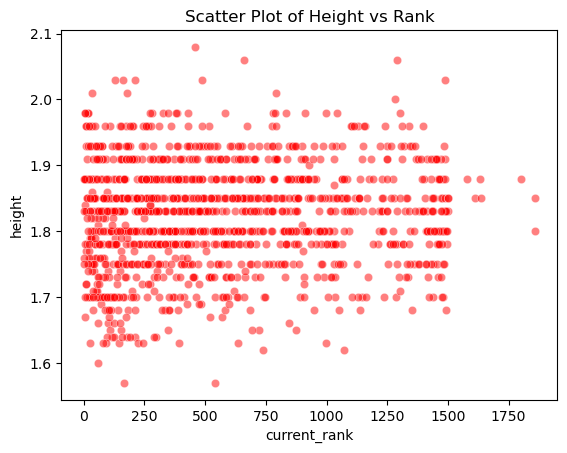

In [228]:
# Load the data.
home_df = pd.read_csv("CSVs\\10_home_df.csv")
away_df = pd.read_csv("CSVs\\10_away_df.csv")
players_df = pd.concat([home_df,away_df])

# Dropping the duplicated players, and ignoring null heights.
players_df.drop_duplicates(subset='player_id', inplace=True)
players_df.dropna(inplace=True)

# Data type conversion.
players_df.current_rank = players_df.current_rank.astype(int)

# Scatter plot to detect if there's any correlation pattern?
sns.scatterplot(data = players_df, x='current_rank',y='height', alpha=0.5,color='r')
plt.title("Scatter Plot of Height vs Rank")
plt.show()

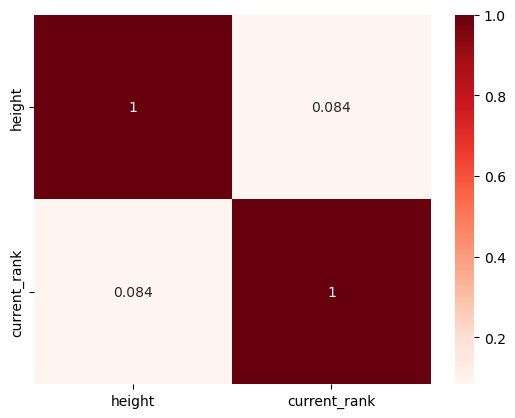

In [ ]:
# Look at correlation matrix.
corr_mat = players_df[['height','current_rank']].corr()
sns.heatmap(corr_mat, annot=True, cmap='Reds')
plt.show()

In [ ]:
# Both scatter plot and corrlation matrix indicate that there are no siginificat correlation between
# player's height and ranking.

### 11.

In [233]:
# Revert to Question 4, and run the cells to define time_df after outlier detection.
avg_dur = time_df.duration.mean()
print(f"Average duration of matches is {avg_dur:.2f} minutes.")

Average duration of matches is 102.88 minutes.


### 12.

In [ ]:
# Loading the necessary data with dask.
home_addresses = render_addresses('match', date_arr = dates_tuple, kind='home_team')
away_addresses = render_addresses('match', date_arr = dates_tuple, kind='away_team')

games_df = dd.read_parquet(render_addresses('power'))
home_df = dd.read_parquet(home_addresses, columns=['match_id','player_id','gender'])
away_df = dd.read_parquet(away_addresses, columns=['match_id','player_id','gender'])

In [41]:
# Extracting the results into csv for faster manipulation with pandas.
with ProgressBar():
    result = away_df.compute()

[########################################] | 100% Completed | 102.77 s


In [ ]:
# Save the result for future convenience.
result

,match_id,player_id,gender
0,11998445,192013,M
0,11998446,273680,M
0,11998447,77223,M
0,11998448,88992,M
0,11998449,248846,M
...,...,...,...
0,12212216,72324,M
0,12213156,217437,M
0,12213412,108559,M
0,12213458,74679,M


In [ ]:
# Opening folders and then dropping duplicates.
games_df = pd.read_csv("CSVs\\12_games_df.csv")
home_df = pd.read_csv("CSVs\\12_home_df.csv")
away_df = pd.read_csv("CSVs\\12_away_df.csv")

# Dropping unnecessary columns and dropping duplicates.
games_df.drop(columns=['value','break_occurred'], inplace=True)
games_df.drop_duplicates(inplace=True)

# Dropping duplicates.
home_df.drop_duplicates(subset='match_id', inplace=True)
away_df.drop_duplicates(subset='match_id', inplace=True)

# Adding average number of games per set.
average_games_df = games_df.groupby(['match_id']).agg({'set_num':'max','game_num':'count'}).reset_index()
average_games_df['avg_games'] = average_games_df['game_num']/average_games_df['set_num']

# Making a new dataframe for male and female matches, with average number of games per set.
male_matches_df = home_df.query('gender == "M"').merge(away_df.query('gender == "M"'), on='match_id',how='inner')[['match_id','gender_x']]
male_matches_df.rename(columns={'gender_x':'gender'}, inplace=True)
female_matches_df = home_df.query('gender == "F"').merge(away_df.query('gender == "F"'), on='match_id',how='inner')[['match_id','gender_x']]
female_matches_df.rename(columns={'gender_x':'gender'}, inplace=True)
average_games_gender_df = average_games_df.merge(pd.concat([male_matches_df,female_matches_df]),on='match_id',how='inner')

# Grouping by gender and finding average number of games per set.
average_games_gender_df.groupby('gender').agg({'avg_games':'mean'})

,avg_games
gender,
F,8.974586
M,9.360346


In [1]:
# As we see, the men's competition has more games, and the women's competition has less.

### 13.

In [ ]:
# Loading the necessary data with dask.
home_addresses = render_addresses('match', date_arr = dates_tuple, kind='home_team')
away_addresses = render_addresses('match', date_arr = dates_tuple, kind='away_team')

home_df = dd.read_parquet(home_addresses, columns=['player_id','plays'])
away_df = dd.read_parquet(away_addresses, columns=['player_id','plays'])

In [96]:
# Extracting the results into csv for faster manipulation with pandas.
with ProgressBar():
    result = away_df.compute()

[########################################] | 100% Completed | 96.30 s


In [ ]:
# Save the result for future convenience.
result

,player_id,plays
0,192013,right-handed
0,273680,right-handed
0,77223,right-handed
0,88992,right-handed
0,248846,right-handed
...,...,...
0,72324,right-handed
0,217437,right-handed
0,108559,right-handed
0,74679,right-handed


In [5]:
# Opening folders and then dropping duplicates.
home_df = pd.read_csv("CSVs\\13_home_df.csv")
away_df = pd.read_csv("CSVs\\13_away_df.csv")

# Concatenating the dataframes and dropping duplicates.
players_hand_df = pd.concat([home_df,away_df])
players_hand_df.drop_duplicates(subset=['player_id'],inplace=True)
players_hand_df.dropna(inplace=True)

# Counting the number of right-handed and left-handed players.
hands_df = players_hand_df.plays.value_counts()
hands_df

plays
right-handed    1013
left-handed      133
Name: count, dtype: int64

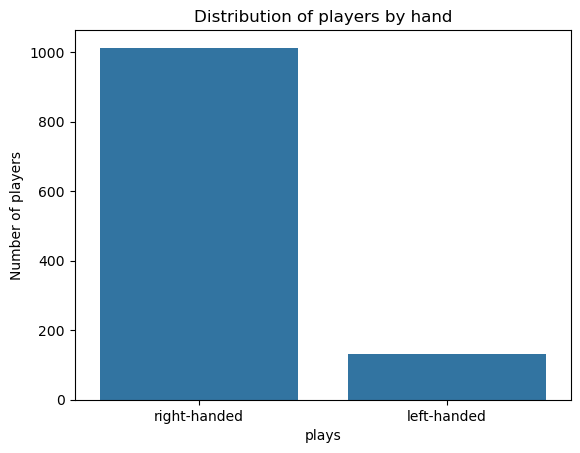

In [ ]:
# Plotting the distribution of players by hand.
sns.barplot(hands_df.reset_index(),x='plays',y='count')
plt.ylabel("Number of players")
plt.title("Distribution of players by hand")
plt.show()

### 14.

In [ ]:
# Loading the necessary data with dask.
tournament_addresses = render_addresses('match', date_arr = dates_tuple, kind='tournament')

# Reading the data.
tournament_df = dd.read_parquet(tournament_addresses, columns=['tournament_id','ground_type'])

In [109]:
# Extracting the results into csv for faster manipulation with pandas.
with ProgressBar():
    result = tournament_df.compute()

[########################################] | 100% Completed | 118.09 s


In [ ]:
# Save the result for future convenience.
result

,tournament_id,ground_type
0,70826,<NA>
0,70826,<NA>
0,126168,Hardcourt indoor
0,126168,Hardcourt indoor
0,126168,Hardcourt indoor
...,...,...
0,128420,Red clay
0,128420,Red clay
0,128420,Red clay
0,128420,Red clay


In [ ]:
# Opening folders and then dropping duplicates.
tournament_df = pd.read_csv("CSVs\\14_tournament_df.csv")
tournament_df.drop_duplicates(inplace=True)
tournament_df.dropna(inplace=True)
tournament_df.ground_type.value_counts()

ground_type
Hardcourt outdoor    239
Red clay             187
Hardcourt indoor      85
Red clay indoor        8
Grass                  8
Carpet indoor          5
Synthetic outdoor      4
Green clay             1
Name: count, dtype: int64

In [8]:
# The most common type of ground is hardcourt outdoor.

### 15.

In [ ]:
# Rendering the addresses for the countries data.
venue_country_addresses = render_addresses('match', date_arr = dates_tuple, kind='venue')
home_addresses = render_addresses('match', date_arr = dates_tuple, kind='home_team')
away_addresses = render_addresses('match', date_arr = dates_tuple, kind='away_team')

# Reading the data.
venue_country_df = dd.read_parquet(tournament_addresses, columns=['country'])
home_country_df = dd.read_parquet(home_addresses, columns=['country'])
away_country_df = dd.read_parquet(away_addresses, columns=['country'])

In [127]:
# Extracting the results into csv for faster manipulation with pandas.
with ProgressBar():
    result = away_country_df.compute()

[########################################] | 100% Completed | 105.06 s


In [ ]:
# Save the result for future convenience.
result

,country
0,Canada
0,Italy
0,Spain
0,France
0,France
...,...
0,Argentina
0,Colombia
0,Spain
0,Sweden


In [ ]:
# Opening folders and then dropping duplicates.
venue_df = pd.read_csv("CSVs\\15_venue_df.csv")
home_df = pd.read_csv("CSVs\\15_home_df.csv")
away_df = pd.read_csv("CSVs\\15_away_df.csv")

# Concatenating the dataframes and dropping duplicates.
countries_df = pd.concat([venue_df,home_df,away_df])
countries_df.dropna(inplace=True)
print(f"There are {countries_df.country.unique().shape[0]} unique countries in the dataset.\n")
print(countries_df.country.unique())

There are 108 unique countries in the dataset.

['Netherlands' 'Lithuania' 'France' 'Australia' 'USA' 'Germany' 'Brazil'
 'Egypt' 'Thailand' 'Austria' 'Uzbekistan' 'New Zealand' 'Portugal'
 'Turkey' 'Tunisia' 'India' 'China' 'Vietnam' 'Serbia' 'Hungary' 'Finland'
 'Sweden' 'Canada' 'Colombia' 'Norway' 'El Salvador' 'Chinese Taipei'
 'Hong Kong' 'Cyprus' 'Pakistan' 'Bulgaria' 'Togo' 'Ireland' 'Croatia'
 'United Arab Emirates' 'Argentina' 'Romania' 'Czech Republic' 'Greece'
 'Bolivia' 'Uruguay' 'Paraguay' 'Chile' 'Jamaica' 'Mexico' 'England'
 'Qatar' 'Bahrain' 'Spain' 'Scotland' 'South Africa' 'Italy' 'Malaysia'
 'Iran' 'Rwanda' 'Slovakia' 'Switzerland' 'Dominican Republic'
 'Kazakhstan' 'Japan' 'Sri Lanka' 'Slovenia' 'Burundi' 'Morocco' 'Denmark'
 'Syria' 'Belgium' 'South Korea' 'Russia' 'Ukraine' 'Latvia'
 'United Kingdom' 'Belarus' 'Poland' 'Algeria' 'Bosnia & Herzegovina'
 'Malta' 'Lebanon' 'Georgia' 'Philippines' 'Venezuela' 'New Caledonia'
 'Israel' 'Estonia' 'Nigeria' 'Guadeloupe'

### 16.

In [6]:
# Rendering the addresses for the countries data.
home_addresses = render_addresses('match', date_arr = dates_tuple, kind='home_team')
away_addresses = render_addresses('match', date_arr = dates_tuple, kind='away_team')

# Reading the data.
home_df = dd.read_parquet(home_addresses, columns=['match_id', 'player_id', 'full_name', 'current_rank'])
away_df = dd.read_parquet(away_addresses, columns=['match_id', 'player_id', 'full_name', 'current_rank'])

In [9]:
# Extracting the results into csv for faster manipulation with pandas.
with ProgressBar():
    result = away_df.compute()

[########################################] | 100% Completed | 114.83 s


In [10]:
result

,match_id,player_id,full_name,current_rank
0,11998445,192013,"Auger-Aliassime, Felix",30
0,11998446,273680,Flavio Cobolli,69
0,11998447,77223,"Martinez, Pedro",101
0,11998448,88992,"Muller, Alexandre",81
0,11998449,248846,"Mayot, Harold",132
...,...,...,...,...
0,12212216,72324,"Doria, Luciano",1442
0,12213156,217437,"Soriano Barrera, Adria",465
0,12213412,108559,"Taberner, Carlos",358
0,12213458,74679,"Simonsson, Fred",None


In [19]:
# Read the necessary CSV files
home_df = pd.read_csv("CSVs\\16_home_df.csv")
away_df = pd.read_csv("CSVs\\16_away_df.csv")
event_df = pd.read_csv("CSVs\\3_match_df.csv")

# Merge home and away data for each match, so each row contains both players' info
matches = home_df.merge(away_df, on='match_id', suffixes=('_home', '_away'))
matches = matches.merge(event_df, on='match_id')
matches.drop_duplicates(subset='match_id', inplace=True)

# Create a DataFrame for home players vs away opponents
home_matches = matches[['player_id_home', 'full_name_home', 'current_rank_away', 'winner_code']]
home_matches['is_win'] = home_matches['winner_code'] == 1
home_matches = home_matches.rename(columns={
    'player_id_home': 'player_id',
    'full_name_home': 'full_name',
    'current_rank_away': 'opponent_rank'
})

# Create a DataFrame for away players vs home opponents
away_matches = matches[['player_id_away', 'full_name_away', 'current_rank_home', 'winner_code']]
away_matches['is_win'] = away_matches['winner_code'] == 2
away_matches = away_matches.rename(columns={
    'player_id_away': 'player_id',
    'full_name_away': 'full_name',
    'current_rank_home': 'opponent_rank'
})

# Combine both DataFrames to have all player vs opponent records
all_matches = pd.concat([home_matches, away_matches], ignore_index=True)

# Filter only matches where the opponent's rank is 10 or better (Top 10)
top10_matches = all_matches[all_matches['opponent_rank'] <= 10]

# Group by player and calculate total matches and wins vs Top 10
summary = top10_matches.groupby(['player_id', 'full_name']).agg(
    total_vs_top10=('is_win', 'count'),
    wins_vs_top10=('is_win', 'sum')
)
summary['win_pct_vs_top10'] = summary['wins_vs_top10'] / summary['total_vs_top10']

# consider players with more than 5 matches vs Top 10 for reliability
summary = summary[summary['total_vs_top10'] > 5]

# Find the player with the highest win percentage vs Top 10
best_player = summary['win_pct_vs_top10'].idxmax()
best_row = summary.loc[best_player]

print(f"Player with highest win percentage vs Top 10: {best_row.name[1]} (ID: {best_row.name[0]})")
print(f"Win percentage: {best_row['win_pct_vs_top10']:.2%} ({int(best_row['wins_vs_top10'])} wins out of {int(best_row['total_vs_top10'])} matches)")

Player with highest win percentage vs Top 10: Dimitrov, Grigor (ID: 23581)
Win percentage: 50.00% (3 wins out of 6 matches)


### 17.

In [29]:
# Rendering the addresses for the countries data.
pbp_addresses = render_addresses('pbp', date_arr = ["20240201"])

# Reading the data.
pbp_df = dd.read_parquet(pbp_addresses)

In [30]:
# Extracting the results into csv for faster manipulation with pandas.
with ProgressBar():
    result = pbp_df.compute()

[########################################] | 100% Completed | 1.16 sms


In [31]:
result

,match_id,set_id,game_id,point_id,home_point,away_point,point_description,home_point_type,away_point_type,home_score,away_score,serving,scoring
0,11998445,3,13,0,1,0,0,6,5,6,7,1,2
1,11998445,3,13,1,1,1,0,5,6,6,7,1,2
2,11998445,3,13,2,1,2,0,5,6,6,7,1,2
3,11998445,3,13,3,1,3,0,5,1,6,7,1,2
4,11998445,3,13,4,1,4,0,5,1,6,7,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,12025672,1,2,2,30,15,2,5,1,1,1,1,1
142,12025672,1,2,3,40,15,0,1,5,1,1,1,1
143,12025672,1,1,0,0,15,0,5,1,0,1,2,2
144,12025672,1,1,1,0,30,0,5,1,0,1,2,2
